<a href="https://colab.research.google.com/github/Priyojit02/Crypto-Trading-Agent-using-Deep-Q-Learning/blob/main/notebooke3b3537cff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install yfinance torch gym numpy pandas matplotlib


In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Define the Crypto Trading Environment
class CryptoTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.crypto_held = 0
        self.done = False
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.crypto_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            self.data.iloc[self.current_step]['Open'],
            self.data.iloc[self.current_step]['High'],
            self.data.iloc[self.current_step]['Low'],
            self.data.iloc[self.current_step]['Close'],
            self.balance,
            self.crypto_held
        ])
        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        if action == 0:  # Buy
            if self.balance > current_price:
                self.crypto_held += self.balance / current_price
                self.balance = 0
        elif action == 1:  # Sell
            if self.crypto_held > 0:
                self.balance += self.crypto_held * current_price
                self.crypto_held = 0

        self.net_worth = self.balance + self.crypto_held * current_price
        self.current_step += 1
        self.done = self.current_step >= len(self.data) - 1

        return self._next_observation(), self.net_worth, self.done, {}

# Define the DQN agent
class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=2000)
        self.model = self.build_model(input_dim, output_dim)

    def build_model(self, input_dim, output_dim):
        model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(3)
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            target = reward
            if not done:
                next_state = torch.FloatTensor(next_state).unsqueeze(0)
                target += self.gamma * torch.max(self.model(next_state)).item()

            state = torch.FloatTensor(state).unsqueeze(0)
            target_f = self.model(state)
            target_f[0][action] = target

            optimizer = optim.Adam(self.model.parameters())
            loss = nn.MSELoss()(target_f, state)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Load the data using yfinance
data = yf.download('BTC-USD', start='2020-01-01', end='2021-01-01', interval='1d')

# Define the Crypto Trading Environment
class CryptoTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(CryptoTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.net_worth = initial_balance
        self.crypto_held = 0
        self.done = False
        self.action_space = gym.spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.crypto_held = 0
        self.current_step = 0
        return self._next_observation()

    def _next_observation(self):
        # Ensure all elements in the observation are floats
        obs = np.array([
            float(self.data.iloc[self.current_step]['Open']),
            float(self.data.iloc[self.current_step]['High']),
            float(self.data.iloc[self.current_step]['Low']),
            float(self.data.iloc[self.current_step]['Close']),
            float(self.balance),
            float(self.crypto_held)
        ], dtype=np.float32)  # Explicitly define the dtype as float32
        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        if action == 0:  # Buy
            if self.balance > current_price:
                self.crypto_held += self.balance / current_price
                self.balance = 0
        elif action == 1:  # Sell
            if self.crypto_held > 0:
                self.balance += self.crypto_held * current_price
                self.crypto_held = 0

        self.net_worth = self.balance + self.crypto_held * current_price
        self.current_step += 1
        self.done = self.current_step >= len(self.data) - 1

        return self._next_observation(), self.net_worth, self.done, {}



[*********************100%***********************]  1 of 1 completed


In [ ]:
import yfinance as yf
import pandas as pd

# Downloading Bitcoin data from Yahoo Finance
data = yf.download('BTC-USD', start='2020-01-01', end='2021-01-01', interval='1d')

# Preview the data
data.head()



[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2020-01-01 00:00:00+00:00,7200.174316,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02 00:00:00+00:00,6985.470215,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03 00:00:00+00:00,7344.884277,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04 00:00:00+00:00,7410.656738,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05 00:00:00+00:00,7411.317383,7411.317383,7544.497070,7400.535645,7410.451660,19725074095


In [ ]:
# Training loop
num_episodes = 1000
batch_size = 32

for e in range(num_episodes):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)

    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if done:
            print(f"Episode: {e+1}/{num_episodes}, Net Worth: {env.net_worth}")
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)


/tmp/ipykernel_30/384460096.py:142: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Open']),
/tmp/ipykernel_30/384460096.py:143: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['High']),
/tmp/ipykernel_30/384460096.py:144: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Low']),
/tmp/ipykernel_30/384460096.py:145: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Close']),


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import matplotlib.pyplot as plt

# Example code to plot net worth progression over episodes
episodes = list(range(1, num_episodes+1))
net_worths = []  # Store net worths over episodes

for e in episodes:
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)

    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        state = next_state

        if done:
            net_worths.append(env.net_worth)
            break

# Plot the net worth progression
plt.plot(episodes, net_worths)
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Net Worth over Episodes')
plt.show()


/tmp/ipykernel_30/384460096.py:142: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Open']),
/tmp/ipykernel_30/384460096.py:143: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['High']),
/tmp/ipykernel_30/384460096.py:144: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Low']),
/tmp/ipykernel_30/384460096.py:145: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(self.data.iloc[self.current_step]['Close']),


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
torch.save(agent.model.state_dict(), 'crypto_trading_dqn.pth')


In [ ]:
import pandas as pd
import numpy as np

# Generate synthetic cryptocurrency data
np.random.seed(42)
dates = pd.date_range(start='2023-01-01', periods=100)
data = {
    'Open': np.random.uniform(low=30000, high=60000, size=(100,)),
    'High': np.random.uniform(low=30000, high=60000, size=(100,)),
    'Low': np.random.uniform(low=30000, high=60000, size=(100,)),
    'Close': np.random.uniform(low=30000, high=60000, size=(100,))
}
crypto_data = pd.DataFrame(data, index=dates)

# Save to CSV
crypto_data.to_csv('crypto_data.csv')


Episode: 1/10, Net Worth: 1000.00
Episode: 2/10, Net Worth: 1000.00
Episode: 3/10, Net Worth: 1000.00
Episode: 4/10, Net Worth: 1000.00
Episode: 5/10, Net Worth: 1000.00
Episode: 6/10, Net Worth: 1000.00
Episode: 7/10, Net Worth: 1000.00
Episode: 8/10, Net Worth: 1000.00
Episode: 9/10, Net Worth: 1000.00
Episode: 10/10, Net Worth: 1000.00


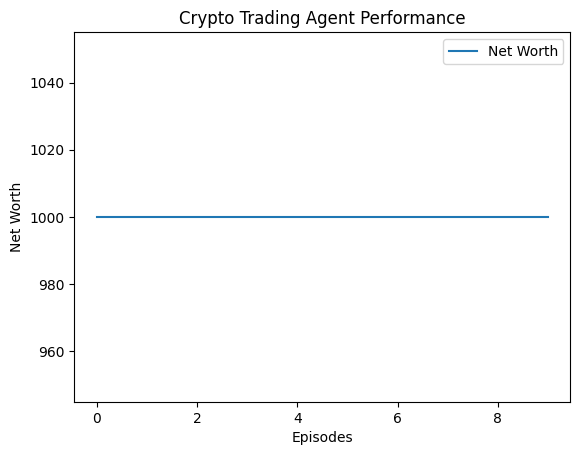

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CryptoTradingEnv:
    def __init__(self, data):
        self.data = data
        self.current_step = 0
        self.balance = 1000  # Starting balance
        self.crypto_held = 0  # Amount of cryptocurrency held
        self.net_worth = self.balance  # Current net worth

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.crypto_held = 0
        self.net_worth = self.balance
        return self._next_observation()

    def _next_observation(self):
        obs = np.array([
            float(self.data.iloc[self.current_step]['Open']),
            float(self.data.iloc[self.current_step]['High']),
            float(self.data.iloc[self.current_step]['Low']),
            float(self.data.iloc[self.current_step]['Close']),
            self.balance,
            self.crypto_held
        ])
        return obs

    def step(self, action):
        current_price = float(self.data.iloc[self.current_step]['Close'])

        if action == 0:  # Buy
            if self.balance > current_price:
                self.crypto_held += self.balance / current_price
                self.balance = 0
        elif action == 1:  # Sell
            if self.crypto_held > 0:
                self.balance += self.crypto_held * current_price
                self.crypto_held = 0

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True
        else:
            done = False

        self.net_worth = self.balance + (self.crypto_held * current_price)
        reward = self.net_worth - (self.balance + self.crypto_held * current_price)  # Simple reward calculation
        return self._next_observation(), reward, done, {}

class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.model = self._build_model()
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_fn = nn.MSELoss()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.output_dim)  # Output dimension must match the number of actions
        )
        return model.to(device)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_dim)
        state = torch.FloatTensor(state).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        mini_batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in mini_batch:
            state_tensor = torch.FloatTensor(state).to(device)
            next_state_tensor = torch.FloatTensor(next_state).to(device)
            target_f = self.model(state_tensor).detach()  # Detach to avoid backpropagating through the model
            target = reward

            if not done:
                target += self.gamma * torch.max(self.model(next_state_tensor).detach()).item()

            target_f[action] = target  # Update the target for the specific action

            self.optimizer.zero_grad()
            loss = self.loss_fn(self.model(state_tensor), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Load data (replace this with your data loading logic)
data = pd.read_csv('crypto_data.csv')  # Ensure your CSV has 'Open', 'High', 'Low', 'Close' columns

# Initialize environment and agent
env = CryptoTradingEnv(data)
state_size = env._next_observation().shape[0]  # Adjusted to get the observation size
action_size = 2  # Buy or sell
agent = DQNAgent(input_dim=state_size, output_dim=action_size)

# Training loop
num_episodes = 100
batch_size = 32

for e in range(num_episodes):
    state = env.reset()
    state = torch.FloatTensor(state).to(device)

    for time in range(500):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = torch.FloatTensor(next_state).to(device)

        agent.remember(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)  # Store in memory
        state = next_state

        if done:
            print(f"Episode: {e + 1}/{num_episodes}, Net Worth: {env.net_worth:.2f}")
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

# Optional: Plotting the performance (requires matplotlib)
import matplotlib.pyplot as plt

plt.plot(range(num_episodes), [env.net_worth for _ in range(num_episodes)], label='Net Worth')
plt.xlabel('Episodes')
plt.ylabel('Net Worth')
plt.title('Crypto Trading Agent Performance')
plt.legend()
plt.show()
